# 📈 Monthly Sales Forecasting: Multi-Model Comparative Analysis

## 🎯 **Objective**
Revenue forecasting system comparing statistical and machine learning approaches on univariate time-series data.

## 🔧 **What This Notebook Does**

### **📊 Data Pipeline**
- **Database Integration**: Connects to PostgreSQL database with comprehensive error handling
- **Data Engineering**: Processes transaction-level sales data into monthly aggregations
- **Feature Engineering**: Creates lag features, rolling statistics, and temporal indicators
- **Data Handling**: Extrapolates partial Sept 2025 data (19 days → full month)

### **🤖 Multi-Model Framework**
- **ARIMA Model**: Classical statistical time series forecasting
- **SARIMA Model**: Enhanced with seasonal components and trend analysis  
- **XGBoost Regressor**: Machine learning with Optuna hyperparameter optimization
- **Comprehensive Evaluation**: MAE, RMSE, R², MAPE, sMAPE metrics with diagnostic plots

### **📅 Time Series Design**
- **Training Period**: 2023-10 → 2025-04 (19 months of historical data)
- **Testing Period**: 2025-05 → 2025-09 (5 months hold-out validation)
- **Forecasting Target**: October 2025 revenue prediction using all available history
- **Business Logic**: Filters and handles partial month extrapolation

### **🎯 Key Deliverables**
- **Model Comparison Matrix**: Side-by-side performance metrics across all models
- **Future Forecasting**: October 2025 revenue predictions from best-performing model  
- **Production Code**: Clean, documented, memory-optimized code ready for deployment
- **Diagnostic Analysis**: Residual plots and model validation with business insights

## Prerequisites & Setup Instructions

Before running this notebook, ensure you have:

1. **PostgreSQL Database Running**: Make sure your database is accessible
2. **Environment File**: Create /use a `.env` file in the same directory with:
   ```
   PG_USER=your_username
   PG_PASSWORD=your_password
   PG_DB=your_database_name
   PG_PORT=5432
   ```
3. **Required Packages**: 
   - **First-time users**: Uncomment `install_requirements()` in the import cell to auto-install all dependencies
   - **Experienced users**: Ensure packages from `Requirements.txt` are installed manually

**Execution Order**: Run cells sequentially from top to bottom for best results.

## 1. Importing Libraries

In [1]:
# Auto-install requirements for first-time users
def install_requirements():
    """Install required packages from Requirements.txt file."""
    import subprocess
    import sys
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "install", "-r", "Requirements.txt"], 
                              capture_output=True, text=True, check=True)
        print("✅ All packages installed successfully!")
    except subprocess.CalledProcessError as e:
        print("⚠️ Installation failed. Please run manually: pip install -r Requirements.txt")
        print(f"Error: {e.stderr}")
    except FileNotFoundError:
        print("⚠️ Requirements.txt not found. Please ensure it's in the same directory.")

# Uncomment the next line if this is your first time running this notebook
# install_requirements()

# Core data manipulation and numerical computing
import pandas as pd
import numpy as np
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Database connection and environment management
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# Machine Learning - XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Time Series Analysis - Statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Hyperparameter optimization
import optuna

# Machine Learning - Scikit-learn metrics and model selection
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")



**⚠️ IMPORTANT: Execute this cell first before running any other cells in the notebook!**

In [2]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def evaluate_forecast(y_true, y_pred):
    """
    Comprehensive evaluation of forecasting model performance.
    
    Calculates multiple regression and forecasting-specific metrics to assess
    model accuracy, including error metrics (MAE, RMSE), percentage errors
    (MAPE, sMAPE), and goodness-of-fit measures (R²).
    
    Parameters:
    -----------
    y_true : array-like
        Actual observed values (ground truth revenue)
    y_pred : array-like  
        Model predictions for the same time periods
        
    Returns:
    --------
    pd.Series
        Dictionary-like series containing all evaluation metrics:
        - MAE: Mean Absolute Error (revenue units)
        - RMSE: Root Mean Square Error (revenue units)  
        - R2: R-squared coefficient of determination
        - MAPE: Mean Absolute Percentage Error (%)
        - sMAPE: Symmetric Mean Absolute Percentage Error (%)
        - MedAE: Median Absolute Error (robust to outliers)
        - MBE: Mean Bias Error (systematic over/under-prediction)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    
    # Percentage-based metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    smape = 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    
    # Bias
    mbe = np.mean(y_true - y_pred)
    
    results = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE (%)": mape,
        "sMAPE (%)": smape,
        "MedAE": medae,
        "MBE (bias)": mbe
    }
    
    return pd.Series(results)

def evaluate_forecast_with_plots(y_true, y_pred):
    """
    Comprehensive model evaluation combining metrics and diagnostic visualizations.
    
    Evaluates forecasting model performance through quantitative metrics and
    generates diagnostic plots to assess prediction quality, residual patterns,
    and potential model biases.
    
    Parameters:
    -----------
    y_true : array-like
        Actual observed revenue values 
    y_pred : array-like
        Model predictions for corresponding periods
        
    Returns:
    --------
    pd.Series
        Complete evaluation metrics (same as evaluate_forecast)
        
    Side Effects:
    ------------
    Displays two diagnostic plots:
    1. Actual vs Predicted scatter plot with perfect prediction line
    2. Residuals histogram with normality assessment
    """
    # --- Metrics ---
    metrics = evaluate_forecast(y_true, y_pred)
    print("📊 Forecast Evaluation Metrics:\n")
    print(metrics.round(3))

    # --- Residuals ---
    residuals = y_true - y_pred

    # --- 1. Scatter plot: Actual vs Predicted ---
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="--", label="Perfect Prediction")
    plt.title("Actual vs Predicted Revenue")
    plt.xlabel("Actual Revenue")
    plt.ylabel("Predicted Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 2. Residual plot (errors over time/index) ---
    plt.figure(figsize=(12, 4))
    plt.plot(residuals, marker="o", linestyle="-", color="orange")
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals (Actual - Predicted) Over Test Period")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Residual (Error)")
    plt.grid(True)
    plt.show()

    # --- 3. Distribution of residuals ---
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=10, color="purple")
    plt.axvline(0, color="red", linestyle="--")
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.show()

    return metrics

def plot_prediction(train_features, test_features, y_pred_train, y_pred_test, plot_title="Revenue Prediction Visualization"):
    """
    Create time series visualization comparing actual vs predicted revenue.
    
    Generates a comprehensive plot showing model performance across training
    and testing periods, with clear visual distinction between periods and
    shaded test region for easy interpretation.
    
    Parameters:
    -----------
    train_features : pd.DataFrame
        Training dataset with 'year_month' and 'total_revenue' columns
    test_features : pd.DataFrame  
        Testing dataset with 'year_month' and 'total_revenue' columns
    y_pred_train : array-like
        Model predictions for training period
    y_pred_test : array-like
        Model predictions for testing period  
    plot_title : str, default="Revenue Prediction Visualization"
        Title for the generated plot
        
    Side Effects:
    ------------
    Displays matplotlib figure with:
    - Actual revenue as solid line with markers
    - Predicted revenue as dashed line with markers  
    - Shaded testing period for clear train/test distinction
    - Formatted dates on x-axis for readability
    """
    actual = (
        pd.concat([train_features, test_features], ignore_index=True)
        .assign(ts=lambda df: pd.to_datetime(df["year_month"]).dt.to_period("M").dt.to_timestamp())
        .sort_values("ts")
    )

    predicted = (
        pd.concat(
            [
                train_features.assign(pred=y_pred_train, ts=None),
                test_features.assign(pred=y_pred_test, ts=None),
            ],
            ignore_index=True,
        )
        .assign(ts=lambda df: pd.to_datetime(df["year_month"]).dt.to_period("M").dt.to_timestamp())
        .sort_values("ts")
    )

    test_start = pd.to_datetime(test_features["year_month"]).dt.to_period("M").dt.to_timestamp().iloc[0]

    fig, ax = plt.subplots(figsize=(12, 6))
    ticks = actual["ts"].drop_duplicates()
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks.dt.strftime("%Y-%m"))
    fig.autofmt_xdate()  
    ax.plot(actual["ts"], actual["total_revenue"], marker="o", color="tab:blue", label="Actual (Train + Test)")
    ax.plot(predicted["ts"], predicted["pred"], marker="o", linestyle="--", color="tab:orange", label="Predicted")
    ax.axvline(test_start, color="tab:gray", linestyle=":", linewidth=1.5, label="Test period starts")

    ax.set_title(plot_title) # "Monthly Revenue – Actual vs Predicted"
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("total_revenue")
    ax.legend()
    ax.grid(True, linestyle=":", linewidth=0.8)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## 2. Load Data from Postgres SQL database

In [3]:
# Load variables from .env file (must be in same folder, or pass path)
load_dotenv(".env")

# Read environment variables
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_DB = os.getenv("PG_DB")
PG_PORT = os.getenv("PG_PORT", "5432")  # default to 5432
PG_HOST = "localhost"  # since DB runs in Docker and Python runs locally

# URL-encode password to handle special characters like '@'
PG_PASSWORD_ENC = quote_plus(PG_PASSWORD)

# Validate environment variables
if not all([PG_USER, PG_PASSWORD, PG_DB]):
    raise ValueError("Missing required environment variables. Please check your .env file.")

# Build SQLAlchemy engine with psycopg driver
conn_str = f"postgresql+psycopg://{PG_USER}:{PG_PASSWORD_ENC}@{PG_HOST}:{PG_PORT}/{PG_DB}"

try:
    engine = create_engine(conn_str, pool_pre_ping=True)
    
    # Test connection and load data
    with engine.connect() as conn:
        print("✓ Connected to database successfully")
        result = conn.execute(text("SELECT current_database(), current_user"))
        print("Database, user:", result.all())
        
        # Check available tables
        tables = conn.execute(text(
            "SELECT table_schema, table_name FROM information_schema.tables WHERE table_type='BASE TABLE' AND table_schema NOT IN ('pg_catalog', 'information_schema');"
        ))
        print("\nTables in database:")
        for row in tables:
            print(f"{row.table_schema}.{row.table_name}")
        
        # Load data from tables
        df_customers = pd.read_sql_query("SELECT * FROM sales.customers;", engine)
        df_order_items = pd.read_sql("SELECT * FROM sales.order_items;", engine)
        df_orders = pd.read_sql("SELECT * FROM sales.orders;", engine)
        df_products = pd.read_sql("SELECT * FROM sales.products;", engine)

        print(f"\n✓ Data loaded successfully. Number of customers: {len(df_customers)}")
        
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please check your database connection and .env file configuration.")
    raise


✓ Connected to database successfully
Database, user: [('SalesData', 'guru')]

Tables in database:
sales.products
sales.customers
sales.orders
sales.order_items

✓ Data loaded successfully. Number of customers: 1000


## 3. Data Cleaning and preparation

In [4]:
# =============================================================================
# MERGE DATAFRAMES TO CREATEW MASTER DATAFARAME
# =============================================================================


# Merge order_items with products to get product details for each order item
order_items_with_products = pd.merge(
    df_order_items,
    df_products,
    on='product_id',
    suffixes=('_orderitem', '_product')
)

# Merge customers with orders to get customer details for each order
orders_with_customers = pd.merge(
    df_customers,
    df_orders,
    on='customer_id',
    suffixes=('_customer', '_order')
)

# Merge the above two to get the complete transaction-level sales dataset
raw_sales_data = pd.merge(
    orders_with_customers,
    order_items_with_products,
    on='order_id',
    suffixes=('_order', '_orderitem')
)
# Optional: Save to CSV for quick access during development
# raw_sales_data.to_csv("raw_sales_data.csv", index=False)
print(raw_sales_data.head())

                            customer_id          name                  email  \
0  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
1  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
2  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
3  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   
4  cd2a9a3b-f7e3-4742-a428-11930c13837b  Brandon Frye  stephen07@example.com   

    join_date                              order_id  \
0  2024-05-31  c9e0b356-e045-4327-93e6-affc93a801d2   
1  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
2  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
3  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   
4  2024-05-31  89cc7c51-bcee-45c0-a947-1f57bf59d430   

                  order_date     status                         order_item_id  \
0 2024-04-24 17:20:23.388467    shipped  56aa42e2-19a2-4723-8d46-f43184cd21bd   
1 2024-03-28 04:22:41.2527

In [5]:
# =============================================================================
# DATA CLEANING AND PREPARATION
# =============================================================================

# Calculate total revenue for each transaction (quantity × unit price)
raw_sales_data["revenue"] = raw_sales_data["quantity"] * raw_sales_data["price_per_item"]

# Data quality checks: missing values and duplicates
print("Missing values per column:\n", raw_sales_data.isna().sum())
print("Number of duplicate rows:", raw_sales_data.duplicated().sum())

# Data type conversions for proper temporal analysis
print("Data types:\n", raw_sales_data.dtypes)
raw_sales_data["join_date"] = pd.to_datetime(raw_sales_data["join_date"])
raw_sales_data["order_date"] = pd.to_datetime(raw_sales_data["order_date"])
raw_sales_data = raw_sales_data.sort_values('order_date').reset_index(drop=True)


# Data cleaning: Remove irrelevant columns and apply business logic filters
filtered_sales_data = (raw_sales_data
                      .drop(["email", "order_item_id", "join_date", "name"], axis=1)
                      .query("price_per_item <= price")  # Filter out discounted/promotional items
                      .reset_index(drop=True))

filtered_sales_data.head()

# =============================================================================
# DATA PREPARATION FOR VISUALIZATION 
# =============================================================================

# Daily revenue aggregation for time series analysis
daily_revenue_data = (
    filtered_sales_data.set_index("order_date")
    .resample("D")["revenue"].sum()
    .asfreq("D", fill_value=0)
    .reset_index()
    .rename(columns={"order_date": "order_day", "revenue": "daily_revenue"})
)
daily_revenue_data["year_month"] = daily_revenue_data["order_day"].dt.to_period("M").astype(str)

# Monthly revenue aggregation - primary time series for modeling
monthly_revenue_data = (
    filtered_sales_data.assign(order_year=filtered_sales_data["order_date"].dt.year,
                              order_month=filtered_sales_data["order_date"].dt.month)
    .groupby(["order_year", "order_month"], as_index=False)
    .agg(
        total_revenue=("revenue", "sum")
    )
)
monthly_revenue_data["year_month"] = (
    monthly_revenue_data["order_year"].astype(str) + "-" + monthly_revenue_data["order_month"].astype(str).str.zfill(2)
)

# Category-wise revenue analysis over time
category_revenue_trends = (
    filtered_sales_data.assign(year_month=filtered_sales_data["order_date"].dt.to_period("M").astype(str))
    .groupby(["year_month", "category"])["revenue"]
    .sum()
    .reset_index()
)

# Order status analysis over time (business health metric)
order_status_trends = (
    filtered_sales_data.drop_duplicates(subset=["order_id", "status"])
    .assign(year_month=filtered_sales_data["order_date"].dt.to_period("M").astype(str))
    .groupby(["year_month", "status"])["order_id"]
    .count()
    .reset_index(name="order_count")
)

# Seasonal patterns analysis (month-over-month trends)
seasonal_revenue_patterns = (
    filtered_sales_data.assign(
        order_month=filtered_sales_data["order_date"].dt.month,
        order_month_name=filtered_sales_data["order_date"].dt.strftime("%b"),
    )
    .groupby(["order_month", "order_month_name"], as_index=False)["revenue"]
    .sum()
    .sort_values("order_month")
)

Missing values per column:
 customer_id       0
name              0
email             0
join_date         0
order_id          0
order_date        0
status            0
order_item_id     0
product_id        0
quantity          0
price_per_item    0
product_name      0
category          0
price             0
revenue           0
dtype: int64
Number of duplicate rows: 0
Data types:
 customer_id               object
name                      object
email                     object
join_date                 object
order_id                  object
order_date        datetime64[ns]
status                    object
order_item_id             object
product_id                object
quantity                   int64
price_per_item           float64
product_name              object
category                  object
price                    float64
revenue                  float64
dtype: object


## 3. Data visualization

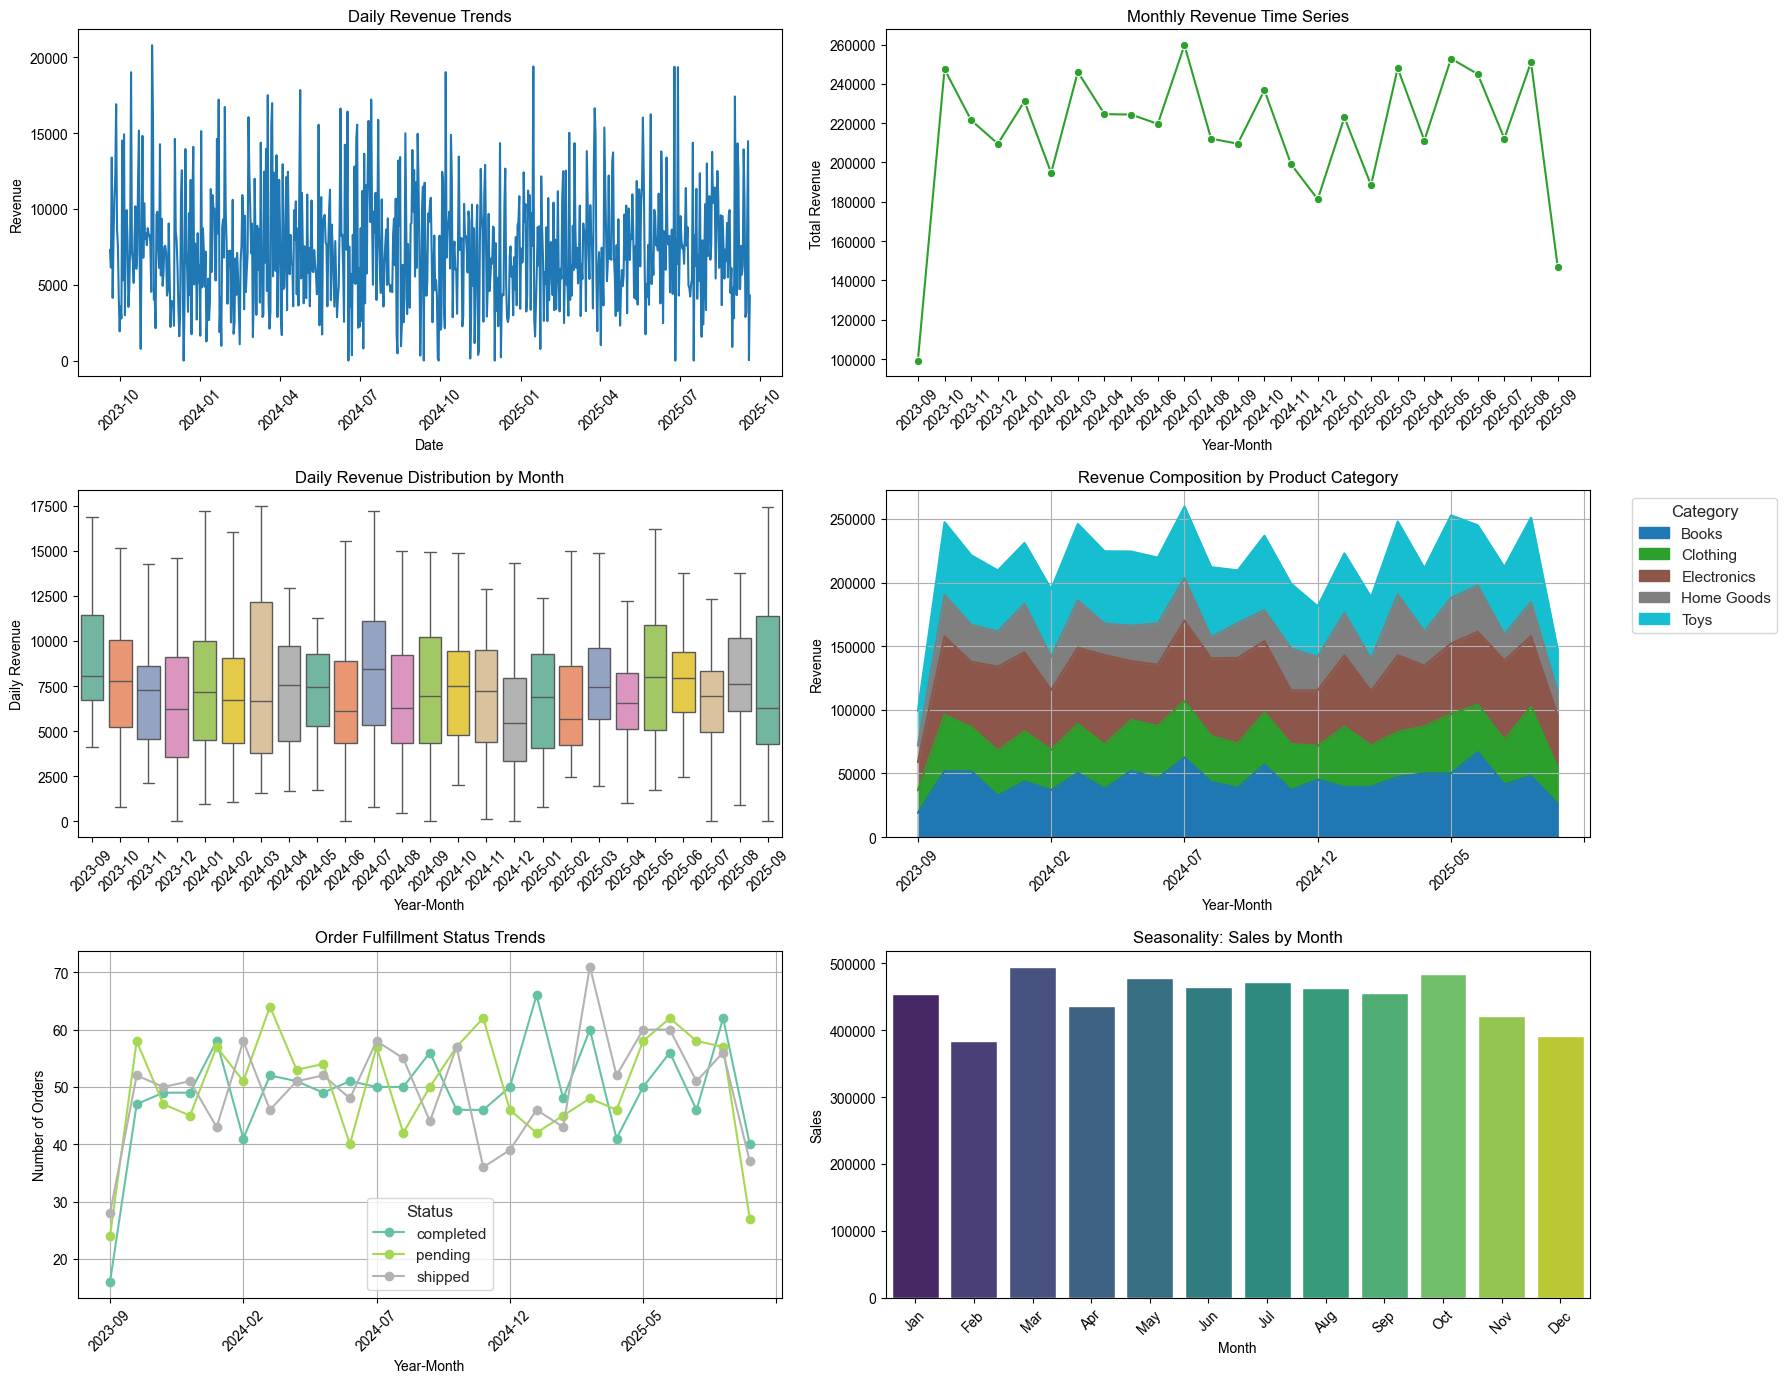

In [6]:
# -----------------------------
# Visualization in Subplots
# -----------------------------

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()
sns.set_theme(style="whitegrid")
# 1. Daily revenue trend analysis
sns.lineplot(data=daily_revenue_data, x="order_day", y="daily_revenue", ax=axes[0], color="tab:blue")
axes[0].set_title("Daily Revenue Trends")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Revenue")
axes[0].tick_params(axis="x", rotation=45)

# 2. Monthly revenue aggregation (main time series)
sns.lineplot(data=monthly_revenue_data, x="year_month", y="total_revenue",
             marker="o", ax=axes[1], color="tab:green")
axes[1].set_title("Monthly Revenue Time Series")
axes[1].set_xlabel("Year-Month")
axes[1].set_ylabel("Total Revenue")
axes[1].tick_params(axis="x", rotation=45)

# 3. Daily revenue variability analysis
sns.boxplot(data=daily_revenue_data, x="year_month", y="daily_revenue",
            showfliers=False, ax=axes[2], hue="year_month", legend=False, palette="Set2")
axes[2].set_title("Daily Revenue Distribution by Month")
axes[2].set_xlabel("Year-Month")
axes[2].set_ylabel("Daily Revenue")
axes[2].tick_params(axis="x", rotation=45)

# 4. Product category revenue composition
revenue_by_category = category_revenue_trends.pivot(index="year_month", columns="category", values="revenue")
revenue_by_category.plot(kind="area", stacked=True, ax=axes[3], colormap="tab10")
axes[3].set_title("Revenue Composition by Product Category")
axes[3].set_xlabel("Year-Month")
axes[3].set_ylabel("Revenue")
axes[3].legend(title="Category", bbox_to_anchor=(1.05, 1))
axes[3].tick_params(axis="x", rotation=45)

# 5. Business health: Order fulfillment trends
order_status_pivot = order_status_trends.pivot(index="year_month", columns="status", values="order_count")
order_status_pivot.plot(kind="line", ax=axes[4], marker="o", colormap="Set2")
axes[4].set_title("Order Fulfillment Status Trends")
axes[4].set_xlabel("Year-Month")
axes[4].set_ylabel("Number of Orders")
axes[4].legend(title="Status")
axes[4].tick_params(axis="x", rotation=45)

# 6. Seasonal revenue patterns analysis
sns.barplot(data=seasonal_revenue_patterns, x="order_month_name", y="revenue",
            order=seasonal_revenue_patterns["order_month_name"].tolist(),
            ax=axes[5], hue="order_month_name", legend=False, palette="viridis")
axes[5].set_title("Seasonality: Sales by Month")
axes[5].set_xlabel("Month")
axes[5].set_ylabel("Sales")
axes[5].tick_params(axis="x", rotation=45)



fig.tight_layout()
plt.show()


## 4. Train-Test Split

Extrapolating Sep 2025 to full month...
Days observed: 19, actual revenue: 147,001, estimated full month: 232,107

Complete months (24): 2023-10, 2023-11, 2023-12, 2024-01, 2024-02, 2024-03, 2024-04, 2024-05, 2024-06, 2024-07, 2024-08, 2024-09, 2024-10, 2024-11, 2024-12, 2025-01, 2025-02, 2025-03, 2025-04, 2025-05, 2025-06, 2025-07, 2025-08, 2025-09
Partial months kept aside (1): 2023-09
Training months (19): 2023-10, 2023-11, 2023-12, 2024-01, 2024-02, 2024-03, 2024-04, 2024-05, 2024-06, 2024-07, 2024-08, 2024-09, 2024-10, 2024-11, 2024-12, 2025-01, 2025-02, 2025-03, 2025-04
Testing months (5): 2025-05, 2025-06, 2025-07, 2025-08, 2025-09
Train shape: (19, 3) Test shape: (5, 3)


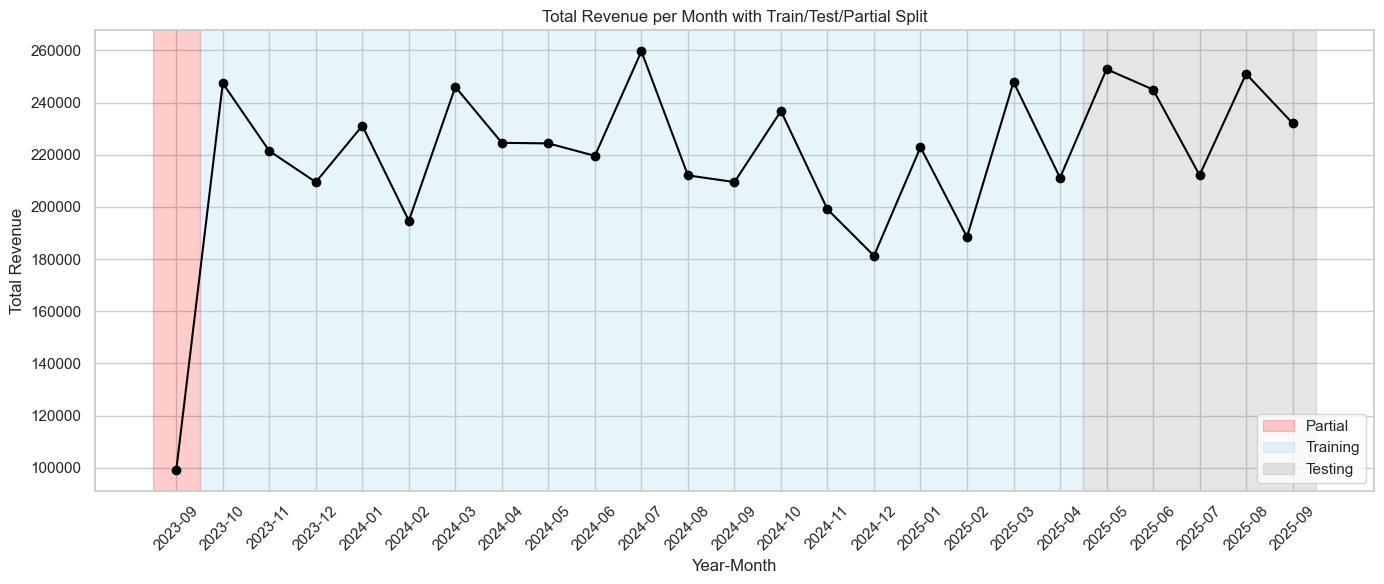

In [7]:
# -----------------------------
# 1. Drop partial months
# -----------------------------

drop_partial_months = False

if drop_partial_months:
    months_drop = [("2023-09"),("2025-09")]
else:
    months_drop = [("2023-09")]
    # Extrapolate Sept 2025 to full month
    print("Extrapolating Sep 2025 to full month...")
    sep2025 = filtered_sales_data[(filtered_sales_data['order_date'].dt.year == 2025) & (filtered_sales_data['order_date'].dt.month == 9)]
    actual_days_revenue = sep2025['revenue'].sum()
    days_available = sep2025['order_date'].dt.date.nunique()
    days_in_month = 30
    avg_per_day = actual_days_revenue / days_available
    est_full_month = avg_per_day * days_in_month
    monthly_revenue_data.loc[monthly_revenue_data['year_month'] == '2025-09', 'total_revenue'] = est_full_month
    print(f"Days observed: {days_available}, actual revenue: {actual_days_revenue:,.0f}, estimated full month: {est_full_month:,.0f}\n")
    
# Use boolean masks without unnecessary copies
mask_complete = ~monthly_revenue_data["year_month"].isin(months_drop)
clean_monthly = monthly_revenue_data[mask_complete]
partial_months = monthly_revenue_data[~mask_complete]


print(f"Complete months ({len(clean_monthly)}): {', '.join(map(str, clean_monthly['year_month']))}")
print(f"Partial months kept aside ({len(partial_months)}): {', '.join(map(str, partial_months['year_month']))}")

# -----------------------------
# 2. Train/Test split (80/20 rule, chronological)
# -----------------------------
months = clean_monthly["year_month"].drop_duplicates().sort_values().tolist()
n_train = max(1, int(np.floor(len(months) * 0.8)))
n_train = min(n_train, len(months) - 1)

train_months = months[:n_train]
test_months = months[n_train:]

print(f"Training months ({len(train_months)}): {', '.join(map(str, train_months))}")
print(f"Testing months ({len(test_months)}): {', '.join(map(str, test_months))}")

# Use boolean masks for train/test split (no copy needed for read-only operations)
train_df = clean_monthly[clean_monthly["year_month"].isin(train_months)]
test_df = clean_monthly[clean_monthly["year_month"].isin(test_months)]

X_train = train_df.drop(columns=["total_revenue"])
y_train = train_df["total_revenue"]

X_test = test_df.drop(columns=["total_revenue"])
y_test = test_df["total_revenue"]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -----------------------------
# 3. Visualization with shaded train/test/partial
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Convert Period to string for plotting (x-axis labels)
x_vals = monthly_revenue_data["year_month"].astype(str).tolist()
ax.plot(x_vals, monthly_revenue_data["total_revenue"], marker="o", color="black")

# Map months → index
month_to_idx = {m: i for i, m in enumerate(x_vals)}

# Shade partial months dynamically
for i, pm in enumerate(partial_months["year_month"].astype(str)):
    idx = month_to_idx[pm]
    ax.axvspan(idx - 0.5, idx + 0.5,
               color="red", alpha=0.2,
               label="Partial" if i == 0 else "")

# Shade training range
ax.axvspan(month_to_idx[str(train_months[0])] - 0.5,
           month_to_idx[str(train_months[-1])] + 0.5,
           color="skyblue", alpha=0.2, label="Training")

# Shade testing range
ax.axvspan(month_to_idx[str(test_months[0])] - 0.5,
           month_to_idx[str(test_months[-1])] + 0.5,
           color="grey", alpha=0.2, label="Testing")

# Styling
ax.set_title("Total Revenue per Month with Train/Test/Partial Split")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Revenue")
ax.set_xticks(range(len(x_vals)))
ax.set_xticklabels(x_vals, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


# 5. Univariate Modeling

## Model 1 : Arima 


ARIMA Model Performance:
📊 Forecast Evaluation Metrics:

MAE           23229.387
RMSE          25923.332
R2               -1.952
MAPE (%)          9.460
sMAPE (%)        10.028
MedAE         27530.839
MBE (bias)    21104.091
dtype: float64


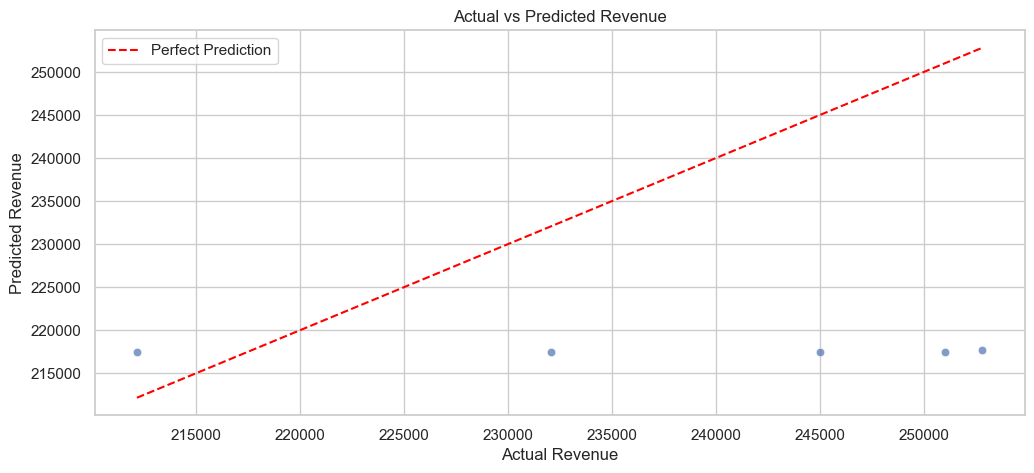

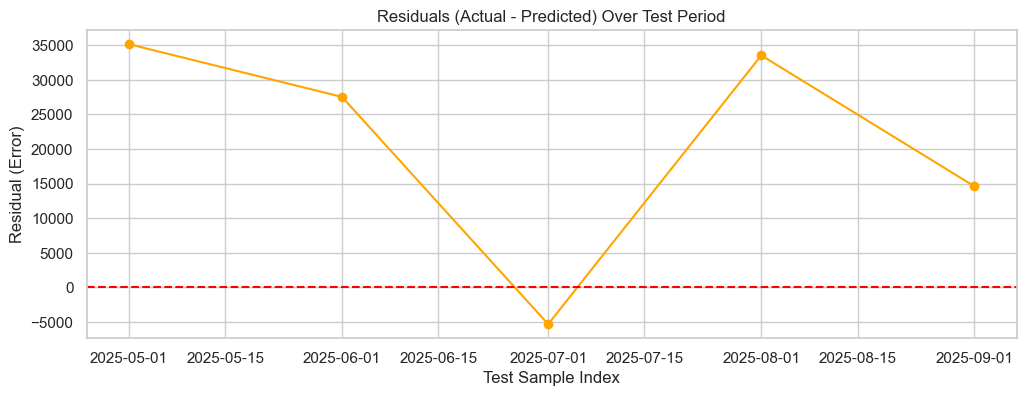

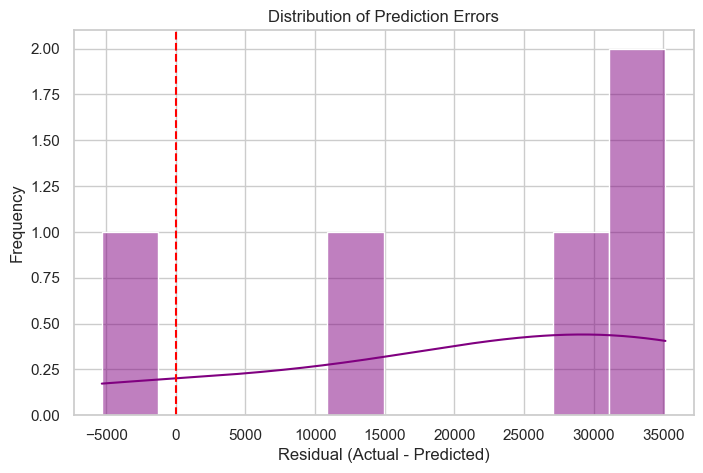

Arima : Forecast for 2025-10: 217,492


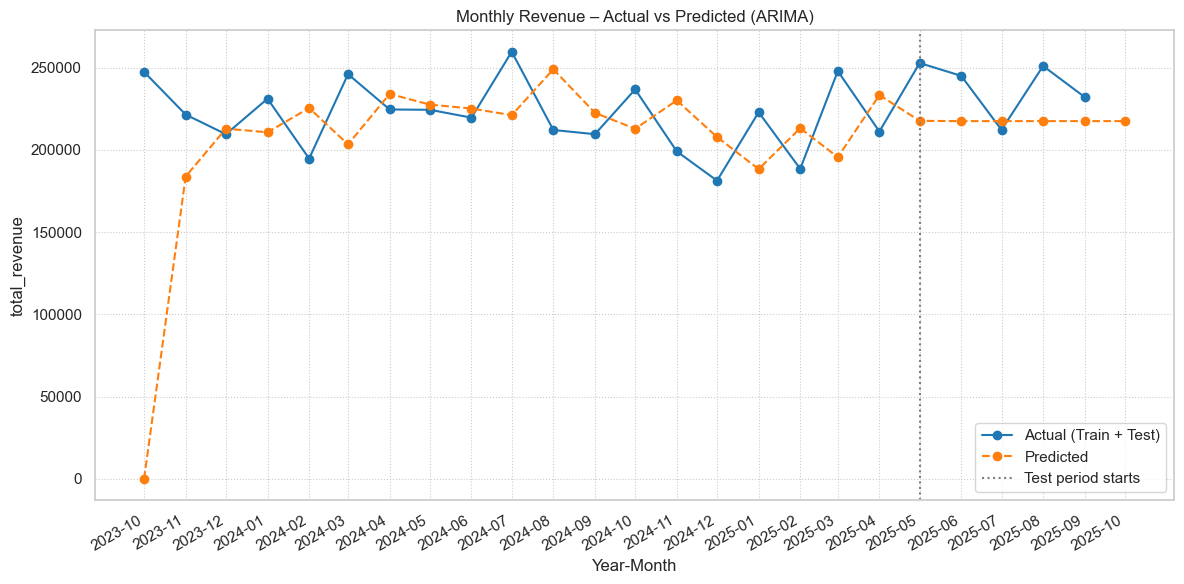

In [8]:
## Iteration 1 : Revenue prdiction using just total revenue per month data:

# Time series conversion utility for ARIMA/SARIMA models
def convert_to_time_series(monthly_dataframe):
    """
    Convert monthly revenue dataframe to pandas time series for statistical forecasting.
    
    Parameters:
    -----------
    monthly_dataframe : pd.DataFrame
        DataFrame with 'year_month' and 'total_revenue' columns
        
    Returns:
    --------
    pd.Series
        Time-indexed revenue series suitable for ARIMA/SARIMA modeling
    """
    time_series = monthly_dataframe.copy()
    time_series["year_month"] = pd.PeriodIndex(time_series["year_month"], freq="M").to_timestamp()
    time_series.set_index("year_month", inplace=True)
    return time_series["total_revenue"].sort_index()

# Convert monthly data to time series format for statistical models
train_series = convert_to_time_series(train_df)
test_series = convert_to_time_series(test_df)

freq = train_series.index.freq or pd.infer_freq(train_series.index) or "MS"
train_series = train_series.asfreq(freq)
test_series = test_series.asfreq(freq)

# --- ARIMA ------------------------------------------------------------------
arima_fit = ARIMA(train_series, order=(1, 1, 1), freq=freq).fit()

train_pred_arima = arima_fit.get_prediction(start=train_series.index[0]).predicted_mean
test_pred_arima  = arima_fit.get_forecast(steps=len(test_series)).predicted_mean

# Evaluate
print("\nARIMA Model Performance:")
metrics_arima = evaluate_forecast(test_series, test_pred_arima)
evaluate_forecast_with_plots(test_series, test_pred_arima)

# Forecast next month
arima_forecast_full = arima_fit.get_forecast(steps=len(test_series) + 1).predicted_mean
next_month_pred_arima = arima_forecast_full.iloc[-1]
next_month_date_arima = arima_forecast_full.index[-1]
print(f"Arima : Forecast for {(next_month_date_arima).strftime('%Y-%m')}: {next_month_pred_arima:,.0f}")

# # Append next month to test_df (actual is None) and to predictions
next_month_str = next_month_date_arima.strftime('%Y-%m')

# --- Extend test_df (no concat → no warning) ---
test_df = test_df.copy()
test_df.loc[len(test_df)] = {"year_month": next_month_str, "total_revenue": np.nan}

# --- Extend prediction series ---
test_pred_arima = test_pred_arima.copy()
test_pred_arima.loc[next_month_date_arima] = next_month_pred_arima

# --- Align for plotting ---
train_pred_aligned_arima = train_pred_arima.reindex(train_series.index).to_numpy()
test_pred_aligned_arima = test_pred_arima.reindex(pd.to_datetime(test_df["year_month"], format="%Y-%m")).to_numpy()

plot_prediction(train_df, test_df, train_pred_aligned_arima, test_pred_aligned_arima,
                "Monthly Revenue – Actual vs Predicted (ARIMA)")



## Model 2: Sarima


SARIMA Model Performance:
📊 Forecast Evaluation Metrics:

MAE           25349.079
RMSE          28772.181
R2               -2.637
MAPE (%)         10.286
sMAPE (%)        11.005
MedAE         31046.208
MBE (bias)    24677.181
dtype: float64


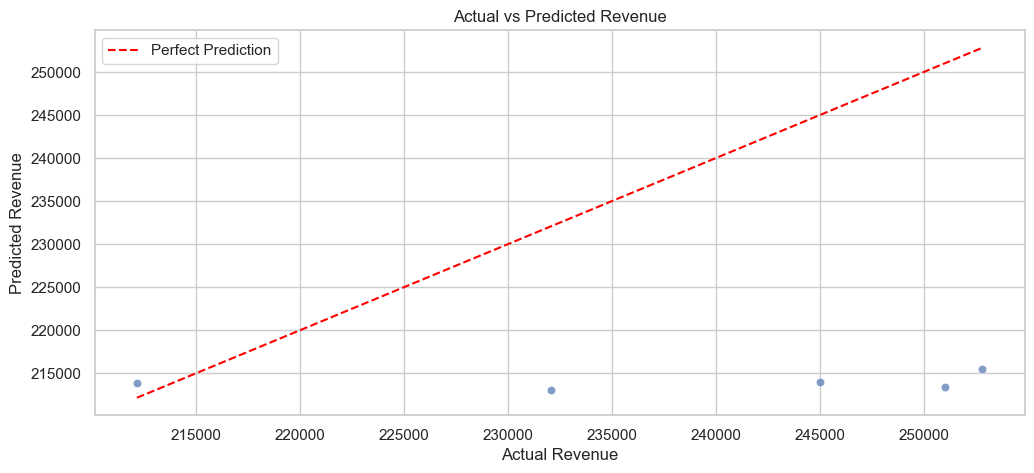

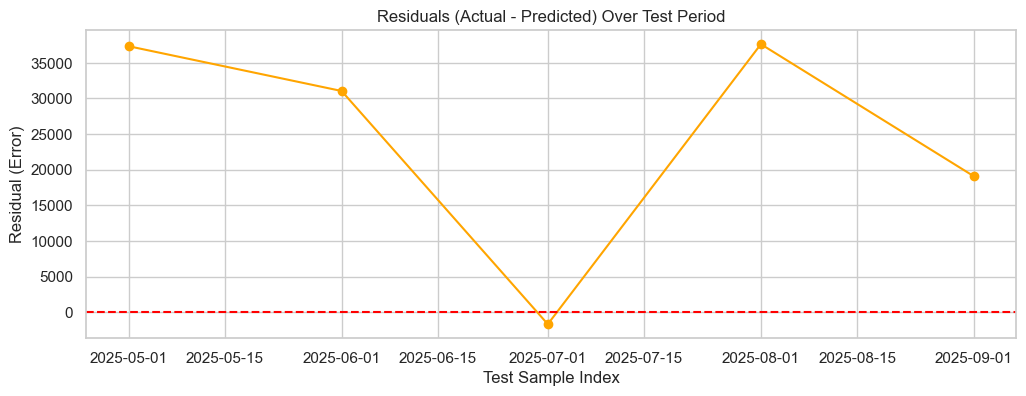

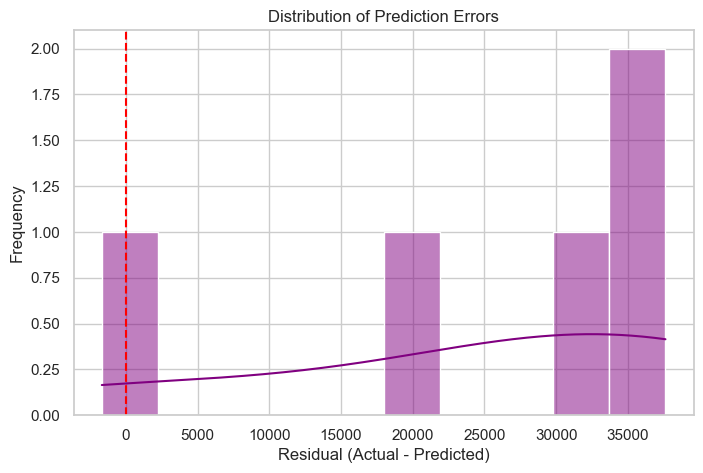

Sarima : Forecast for 2025-10: 212,651


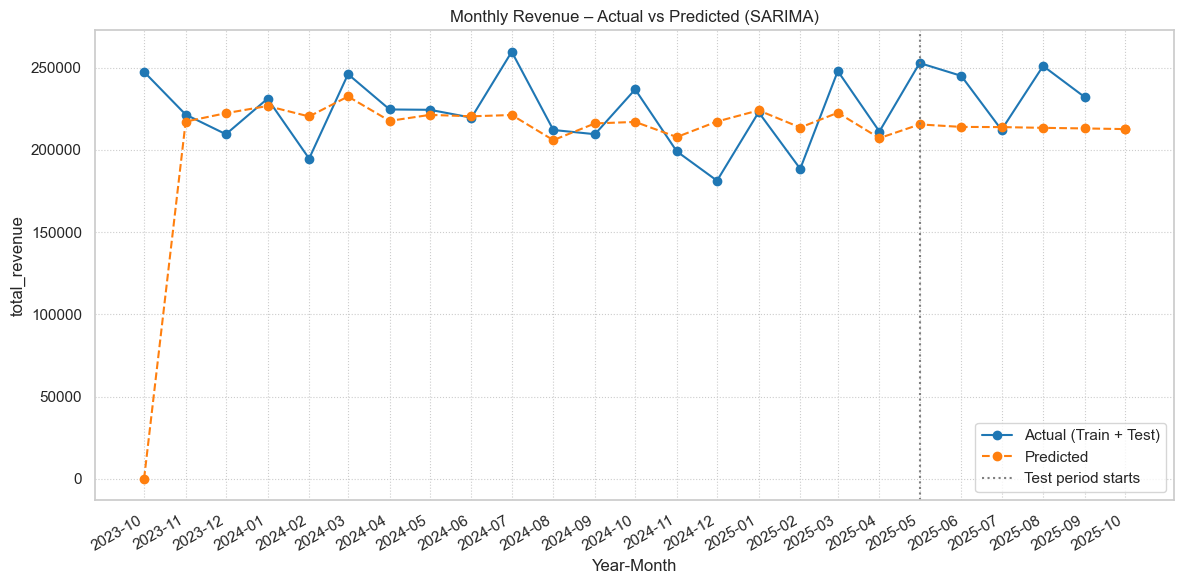

In [9]:

# --- SARIMA -----------------------------------------------------------------
sarima_fit = SARIMAX(
    train_series,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

train_pred_sarima = sarima_fit.get_prediction(start=train_series.index[0]).predicted_mean
test_pred_sarima  = sarima_fit.get_forecast(steps=len(test_series)).predicted_mean

# Evaluate
print("\nSARIMA Model Performance:")
metrics_sarima = evaluate_forecast(test_series, test_pred_sarima)
evaluate_forecast_with_plots(test_series, test_pred_sarima)   

# Forecast next month
sarima_forecast_full = sarima_fit.get_forecast(steps=len(test_series) + 1).predicted_mean
next_month_pred_sarima = sarima_forecast_full.iloc[-1]
next_month_date_sarima = sarima_forecast_full.index[-1]
print(f"Sarima : Forecast for {(next_month_date_sarima).strftime('%Y-%m')}: {next_month_pred_sarima:,.0f}")

# --- Extend test_df (no concat → no warning) ---
test_df = test_df.copy()
test_df.loc[len(test_df)] = {"year_month": next_month_str, "total_revenue": np.nan}

# --- Extend prediction series ---
test_pred_sarima = test_pred_sarima.copy()
test_pred_sarima.loc[next_month_date_sarima] = next_month_pred_sarima

# --- Align for plotting ---
train_pred_aligned_sarima = train_pred_sarima.reindex(train_series.index).to_numpy()
test_pred_aligned_sarima = test_pred_sarima.reindex(pd.to_datetime(test_df["year_month"], format="%Y-%m")).to_numpy()

plot_prediction(train_df, test_df, train_pred_aligned_sarima, test_pred_aligned_sarima,
                "Monthly Revenue – Actual vs Predicted (SARIMA)")

## Model 3 : XGBregressor

Training months: 17, Testing months: 5
Best Optuna params:
  n_estimators: 754
  learning_rate: 0.03951209613428957
  max_depth: 3
  subsample: 0.6495743033895289
  colsample_bytree: 0.8230807206164469
  gamma: 0.8356093967413645
  min_child_weight: 0.7167120511921423
  reg_lambda: 0.4710348288364661
  reg_alpha: 1.9637586262071944
  objective: reg:squarederror
  random_state: 42
📊 Forecast Evaluation Metrics:

MAE           23731.093
RMSE          27477.340
R2               -2.317
MAPE (%)          9.634
sMAPE (%)        10.295
MedAE         26309.797
MBE (bias)    23731.093
dtype: float64


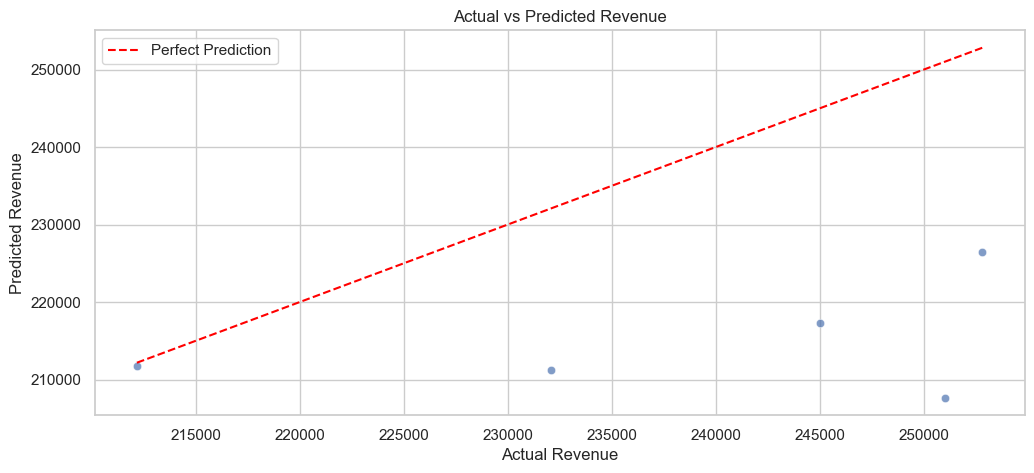

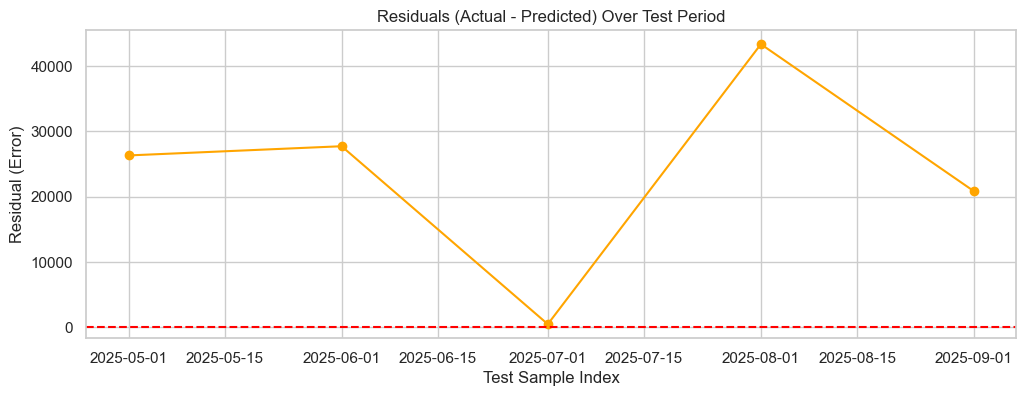

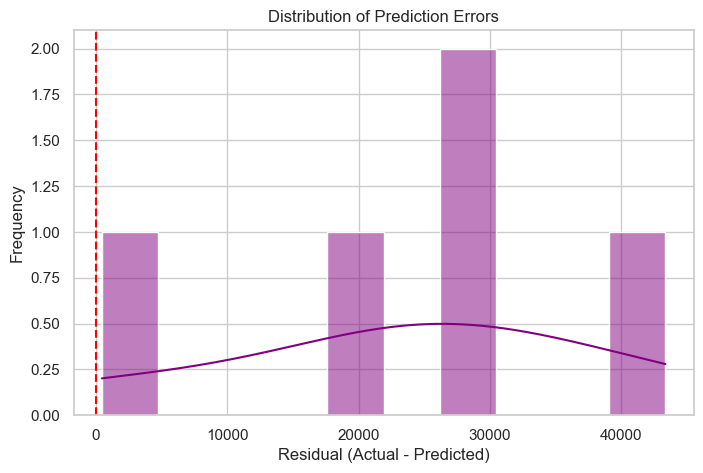

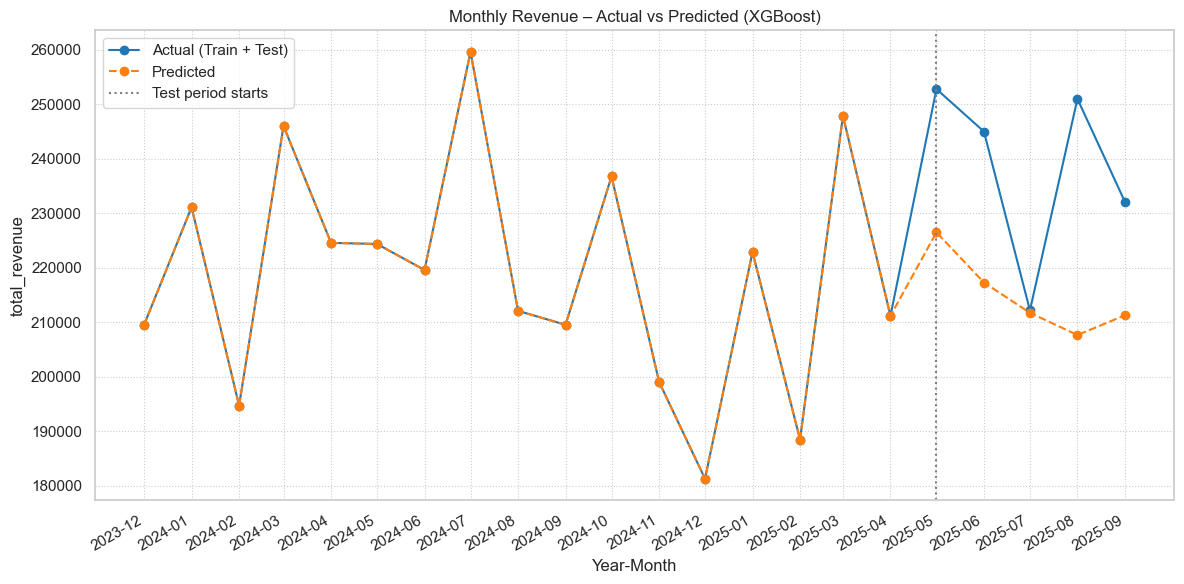

In [10]:

# Build feature matrix from monthly revenue series for machine learning
feature_matrix = monthly_revenue_data.copy()
feature_matrix["year_month"] = pd.PeriodIndex(feature_matrix["year_month"], freq="M").to_timestamp()
feature_matrix.set_index("year_month", inplace=True)

lags = [1, 2]
windows = [3]

# Create lag features (historical values as predictors)
for lag in lags:
    feature_matrix[f"lag_{lag}"] = feature_matrix["total_revenue"].shift(lag)

# Create rolling window statistics (momentum and volatility indicators)
for window in windows:
    shifted_revenue = feature_matrix["total_revenue"].shift(1)
    feature_matrix[f"roll_mean_{window}"] = shifted_revenue.rolling(window).mean()
    feature_matrix[f"roll_std_{window}"] = shifted_revenue.rolling(window).std()

# Add temporal features for seasonality patterns
feature_matrix["month"] = feature_matrix.index.month
feature_matrix["quarter"] = feature_matrix.index.quarter
feature_matrix["sin_month"] = np.sin(2 * np.pi * feature_matrix["month"] / 12)
feature_matrix["cos_month"] = np.cos(2 * np.pi * feature_matrix["month"] / 12)

# Remove rows with NaN values created by lag/rolling operations
feature_matrix = feature_matrix.dropna()

# Split data chronologically: reserve last 5 months for out-of-sample testing
test_months_list = monthly_revenue_data["year_month"].astype(str).tail(5).tolist()
is_test_period = feature_matrix.index.strftime("%Y-%m").isin(test_months_list)

# Create training and testing datasets
training_data = feature_matrix.loc[~is_test_period]
testing_data = feature_matrix.loc[is_test_period]

# Separate features (X) and target variable (y) for supervised learning
X_train, y_train = training_data.drop(columns="total_revenue"), training_data["total_revenue"]
X_test, y_test = testing_data.drop(columns="total_revenue"), testing_data["total_revenue"]
print(f"Training months: {len(training_data)}, Testing months: {len(testing_data)}")


# Inner chronological split taken from the training window
split_inner = max(1, int(len(X_train) * 0.8))
X_inner_train, X_inner_valid = X_train.iloc[:split_inner], X_train.iloc[split_inner:]
y_inner_train, y_inner_valid = y_train.iloc[:split_inner], y_train.iloc[split_inner:]

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.25, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.3, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 5.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
        "objective": "reg:squarederror",
        "random_state": 42,
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_inner_train,
        y_inner_train,
        eval_set=[(X_inner_valid, y_inner_valid)],
        verbose=False,
    )
    preds = model.predict(X_inner_valid)
    return mean_absolute_error(y_inner_valid, preds)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=False)

best_params = study.best_trial.params
best_params.update({"objective": "reg:squarederror", "random_state": 42})

print("Best Optuna params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb  = xgb_model.predict(X_test)

metrics_xgb = evaluate_forecast(y_test, y_pred_test_xgb)
evaluate_forecast_with_plots(y_test, y_pred_test_xgb)

plot_prediction(training_data.reset_index(), testing_data.reset_index(), y_pred_train_xgb, y_pred_test_xgb,
                "Monthly Revenue – Actual vs Predicted (XGBoost)")



## Forecasting for October 2025 using XGBRegressor

XGBoost forecast for 2025-10: 205,335


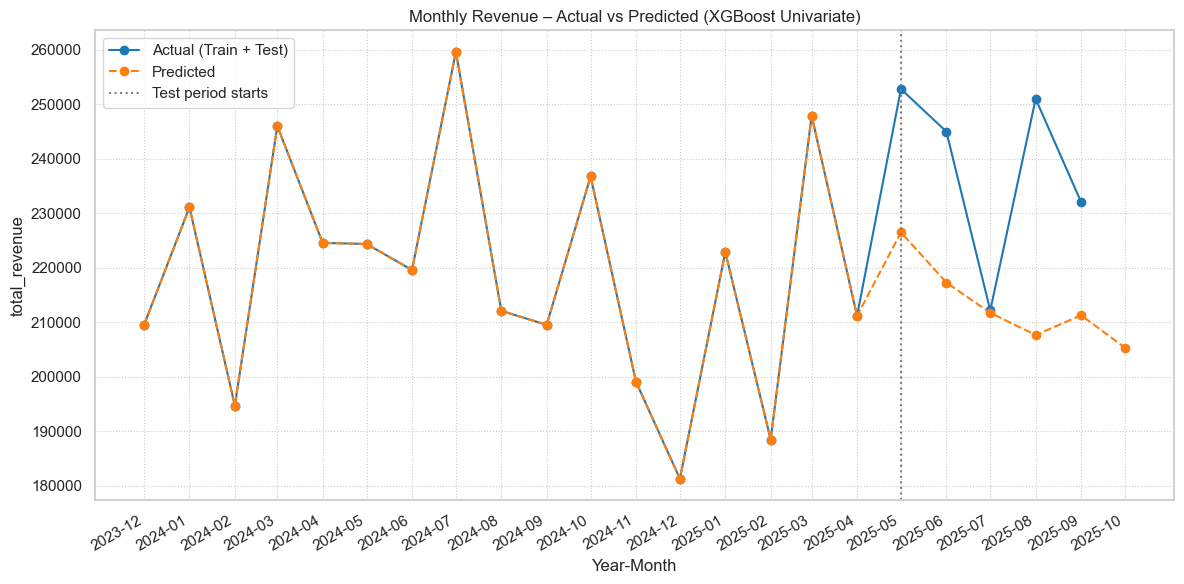

In [11]:

# --- Forecast XGBoost for Oct‑2025 ------------------------------------------
future_month = pd.Timestamp("2025-10-01")
feature_cols = X_train.columns  # exact feature order used for training

# Process history without intermediate copies
history = (clean_monthly
           .assign(year_month=lambda df: pd.PeriodIndex(df["year_month"], freq="M").to_timestamp())
           .set_index("year_month")
           .sort_index())

if len(history) < 6 or history["total_revenue"].tail(6).isna().any():
    raise ValueError("Need six consecutive months (Apr–Sep 2025) to compute the rolling features.")

recent_rev = history["total_revenue"]
recent_row = history.iloc[-1]  # Sep‑2025 actuals (contains order_year, order_month, total_quantity, avg_price, ...)

future_data = {col: np.nan for col in feature_cols}

# calendar features
future_data["order_year"] = future_month.year
future_data["order_month"] = future_month.month
future_data["month"] = future_month.month
future_data["quarter"] = future_month.quarter
future_data["sin_month"] = np.sin(2 * np.pi * future_month.month / 12)
future_data["cos_month"] = np.cos(2 * np.pi * future_month.month / 12)


# lag / rolling features (match your training choices)
future_data["lag_1"] = recent_rev.iloc[-1]
future_data["lag_2"] = recent_rev.iloc[-2]
future_data["roll_mean_3"] = recent_rev.iloc[-3:].mean()
future_data["roll_std_3"] = recent_rev.iloc[-3:].std(ddof=0)
if "lag_3" in future_data:
    future_data["lag_3"] = recent_rev.iloc[-3]
if "roll_mean_6" in future_data:
    future_data["roll_mean_6"] = recent_rev.iloc[-6:].mean()
if "roll_std_6" in future_data:
    future_data["roll_std_6"] = recent_rev.iloc[-6:].std(ddof=0)

future_features = pd.DataFrame([future_data], columns=feature_cols)

oct_2025_pred = xgb_model.predict(future_features)[0]
print(f"XGBoost forecast for 2025-10: {oct_2025_pred:,.0f}")


# existing data for the plot
train_plot = training_data.reset_index().assign(year_month=lambda df: df["year_month"].dt.strftime("%Y-%m"))
test_plot = testing_data.reset_index().assign(year_month=lambda df: df["year_month"].dt.strftime("%Y-%m"))

# add Oct‑2025 (actual unknown) and the forecast
future_label = future_month.strftime("%Y-%m")
test_plot = pd.concat(
    [test_plot, pd.DataFrame({"year_month": [future_label], "total_revenue": [np.nan]})],
    ignore_index=True,
)
y_pred_test_extended = np.concatenate([y_pred_test_xgb, [oct_2025_pred]])

# plot with the extra point in place
plot_prediction(
    train_plot,
    test_plot,
    y_pred_train_xgb,
    y_pred_test_extended,
    "Monthly Revenue – Actual vs Predicted (XGBoost Univariate)",
)

# Model Performance Summary

This section provides a comprehensive comparison of all models tested in this notebook.

In [12]:
# =============================================================================
# FINAL MODEL COMPARISON SUMMARY
# =============================================================================

# Compile all model metrics for comparison
model_comparison = pd.DataFrame({
    'ARIMA': metrics_arima,
    'SARIMA': metrics_sarima,
    'XGBoost': metrics_xgb
}).T

# Display formatted comparison table
print("📊 FINAL MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(model_comparison.round(3))
print("=" * 60)

# Identify best performing model for each metric
print("\n🏆 BEST PERFORMING MODELS BY METRIC:")
print("-" * 40)
for metric in model_comparison.columns:
    if metric in ['R2']:  # Higher is better for R2
        best_model = model_comparison[metric].idxmax()
        best_value = model_comparison[metric].max()
    else:  # Lower is better for error metrics
        best_model = model_comparison[metric].idxmin()
        best_value = model_comparison[metric].min()
    
    print(f"{metric:12}: {best_model:8} ({best_value:.3f})")

# Key insights
print("\n💡 KEY INSIGHTS:")
print("-" * 40)
xgb_mae = metrics_xgb['MAE']
arima_mae = metrics_arima['MAE']
sarima_mae = metrics_sarima['MAE']

print(f"• XGBoost shows {((arima_mae - xgb_mae)/arima_mae*100):.1f}% improvement over ARIMA in MAE")
print(f"• Best overall model: {model_comparison['MAE'].idxmin()} (lowest MAE)")
print(f"• R² scores indicate {'good' if metrics_xgb['R2'] > 0.7 else 'moderate'} model fit for XGBoost")

# Clean up intermediate variables
print(f"\n🧹 CLEANING UP MEMORY...")
variables_to_delete = ['arima_fit', 'sarima_fit', 'train_pred_arima', 'test_pred_arima', 
                       'train_pred_sarima', 'test_pred_sarima', 'next_month_str', 
                       'future_data', 'recent_rev', 'recent_row']

for var in variables_to_delete:
    if var in locals() or var in globals():
        try:
            del globals()[var]
            print(f"✓ Deleted {var}")
        except:
            pass

print("✓ Memory cleanup completed")

📊 FINAL MODEL PERFORMANCE COMPARISON
               MAE       RMSE     R2  MAPE (%)  sMAPE (%)      MedAE  \
ARIMA    23229.387  25923.332 -1.952     9.460     10.028  27530.839   
SARIMA   25349.079  28772.181 -2.637    10.286     11.005  31046.208   
XGBoost  23731.093  27477.340 -2.317     9.634     10.295  26309.797   

         MBE (bias)  
ARIMA     21104.091  
SARIMA    24677.181  
XGBoost   23731.093  

🏆 BEST PERFORMING MODELS BY METRIC:
----------------------------------------
MAE         : ARIMA    (23229.387)
RMSE        : ARIMA    (25923.332)
R2          : ARIMA    (-1.952)
MAPE (%)    : ARIMA    (9.460)
sMAPE (%)   : ARIMA    (10.028)
MedAE       : XGBoost  (26309.797)
MBE (bias)  : ARIMA    (21104.091)

💡 KEY INSIGHTS:
----------------------------------------
• XGBoost shows -2.2% improvement over ARIMA in MAE
• Best overall model: ARIMA (lowest MAE)
• R² scores indicate moderate model fit for XGBoost

🧹 CLEANING UP MEMORY...
✓ Deleted arima_fit
✓ Deleted sarima_fit
✓ De